In [1]:
import gzip
import json
import re
import os
import sys
from pprint import pprint
import time
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import trange

import igraph as ig

import torch
import torch.nn.functional as F
from torch import nn
from torch_geometric.data import HeteroData
from torch_geometric.nn import GCNConv, SAGEConv, VGAE, to_hetero
from torch_geometric.utils import train_test_split_edges
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T
from torch_geometric.loader import LinkNeighborLoader
from torch_geometric.sampler  import NegativeSampling


In [ ]:
import pandas as pd
movies_path = 'ml-latest-small/movies.csv'
ratings_path = 'ml-latest-small/ratings.csv'

# Load the entire movie data frame into memory:
movies_df = pd.read_csv(movies_path, index_col='movieId')

# Split genres and convert into indicator variables:
genres = movies_df['genres'].str.get_dummies('|')
print(genres[["Action", "Adventure", "Drama", "Horror"]].head())

# Use genres as movie input features:
movie_feat = torch.from_numpy(genres.values).to(torch.float)
assert movie_feat.size() == (9742, 20)  # 20 genres in total.

# Load the entire ratings data frame into memory:
ratings_df = pd.read_csv(ratings_path)

# Create a mapping from unique user indices to range [0, num_user_nodes):
unique_user_id = ratings_df['userId'].unique()
unique_user_id = pd.DataFrame(data={
    'userId': unique_user_id,
    'mappedID': pd.RangeIndex(len(unique_user_id)),
})
print("Mapping of user IDs to consecutive values:")
print("==========================================")
print(unique_user_id.head())
print()
# Create a mapping from unique movie indices to range [0, num_movie_nodes):
unique_movie_id = ratings_df['movieId'].unique()
unique_movie_id = pd.DataFrame(data={
    'movieId': movies_df.index,
    'mappedID': pd.RangeIndex(len(movies_df)),
})
print("Mapping of movie IDs to consecutive values:")
print("===========================================")
print(unique_movie_id.head())

# Perform merge to obtain the edges from users and movies:
ratings_user_id = pd.merge(ratings_df['userId'], unique_user_id,
                            left_on='userId', right_on='userId', how='left')
ratings_user_id = torch.from_numpy(ratings_user_id['mappedID'].values)
ratings_movie_id = pd.merge(ratings_df['movieId'], unique_movie_id,
                            left_on='movieId', right_on='movieId', how='left')
ratings_movie_id = torch.from_numpy(ratings_movie_id['mappedID'].values)

# With this, we are ready to construct our `edge_index` in COO format
# following PyG semantics:
edge_index_user_to_movie = torch.stack([ratings_user_id, ratings_movie_id], dim=0)
assert edge_index_user_to_movie.size() == (2, 100836)

print()
print("Final edge indices pointing from users to movies:")
print("=================================================")
print(edge_index_user_to_movie)

In [ ]:
from torch_geometric.data import HeteroData
import torch_geometric.transforms as T

graph_data = HeteroData()

# Save node indices:
graph_data["user"].node_id = torch.arange(len(unique_user_id))
graph_data["item"].node_id = torch.arange(len(movies_df))

# # Add the node features and edge indices:
graph_data["item"].x = movie_feat
graph_data["user", "interacts", "item"].edge_index = edge_index_user_to_movie

# We also need to make sure to add the reverse edges from movies to users
# in order to let a GNN be able to pass messages in both directions.
# We can leverage the `T.ToUndirected()` transform for this from PyG:
graph_data = T.ToUndirected()(graph_data)
graph_data

HeteroData(
  user={ node_id=[610] },
  item={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, interacts, item)={ edge_index=[2, 100836] },
  (item, rev_interacts, user)={ edge_index=[2, 100836] }
)

In [ ]:
from model import *

from src.data_loader import GraphLoader
from src.batch_loader import BatchLoader
from src.registry import MODEL_REGISTRY
from src.utils import *


In [ ]:
import os
import sys
import logging
import pathlib
import argparse
import yaml
import pprint
import time
from collections import Counter, defaultdict
from tqdm import trange

DIR = pathlib.Path().resolve()
PLOT_DIR = DIR / "plots"

os.makedirs(PLOT_DIR, exist_ok=True)

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

logging.basicConfig(
    # filename=DIR / 'train.log',
    # filemode='w',
    level=logging.DEBUG,
    datefmt='%m-%d %H:%M:%S',
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
)
logging.getLogger("matplotlib").setLevel(logging.WARNING)
logging.getLogger("PIL").setLevel(logging.WARNING)
logger = logging.getLogger(__name__)

# ch = logging.StreamHandler()
# ch.setLevel(logging.INFO) # or any other level
# logger.addHandler(ch)

# Parser
parser = argparse.ArgumentParser(description="Load parquet datasets")
parser.add_argument("--config", type=str, default=f"{DIR}/config.yaml", help="Path to YAML config file")
args, unknown = parser.parse_known_args()

with open(args.config, "r") as f:
    cfg = yaml.safe_load(f)

logger.info("Configuration:")
logger.info(pprint.pformat(cfg))


09-03 18:46:50 - INFO - __main__ - Configuration:
09-03 18:46:50 - INFO - __main__ - {'batch_method': 'binary_link_neighbors',
 'batch_norm': False,
 'batch_size': 128,
 'book_features': None,
 'books_filename': 'books_filtered.parquet',
 'coreness_k': 10,
 'decoder': 'inner_product_decoder',
 'descriptions_filename': 'descriptions_filtered.parquet',
 'dir': './data_sample',
 'disjoint_train_ratio': 0.0,
 'embeddings_descriptions_filename': 'embeddings_descriptions_sbert_pt.parquet',
 'embeddings_reviews_filename': 'embeddings_reviews_sbert_pt.parquet',
 'encoder': 'sage_encoder',
 'epochs': 10,
 'eval_interval': 1,
 'hidden_channels': 32,
 'interactions_filename': 'interactions.parquet',
 'item_emb_dim': 64,
 'language_filter': True,
 'latent_dim': 16,
 'learning_rate': 0.0001,
 'n_layer': 1,
 'negative_sampling_method': 'batch_random',
 'negative_sampling_ratio': 2.0,
 'negative_sampling_recurrence': 'epoch',
 'num_neighbors': [10, 10],
 'patience': 50,
 'recon_loss': 'binary',
 'rev

In [7]:
# Split the data into train/val/test sets
train_val_test_split = random_link_split(cfg)
train_data, val_data, test_data = train_val_test_split(graph_data)

logger.debug(f"Train: {train_data}")
logger.debug(f"Val: {val_data}")
logger.debug(f"Test: {test_data}")

# batch loader
batch_loader = BatchLoader(cfg)
train_loader = batch_loader.load(train_data, shuffle=True)

# val_loader = batch_loader.load(val_data, shuffle=False)
# test_loader = batch_loader.load(test_data, shuffle=False)


################################################################################################
############################                MODEL                ###############################
################################################################################################
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

val_data = val_data.to(device)
test_data = test_data.to(device)

encoder = MODEL_REGISTRY.get(cfg['encoder'], VarSageEncoder)
decoder = MODEL_REGISTRY.get(cfg['decoder'], InnerProductDecoder)

model = VGAE(
    data=train_data,
    encoder=encoder,
    decoder=decoder,
    cfg=cfg
).to(device)

pprint.pprint(model)
optimizer = torch.optim.AdamW(model.parameters(), lr=cfg['learning_rate'], weight_decay=cfg['weight_decay'])

################################################################################################
############################                TRAIN                ###############################
################################################################################################

history = {
    "train" : defaultdict(list),
    "val" : defaultdict(list),
}

best_model_cfg = {
    "best_model": None,
    "best_loss": float('inf'),
    "epoch": 0,
    "auc": 0,
    "average_precision": 0
}

sampling_strategy = cfg.get('sampling_strategy', 'batch_random')

09-03 18:46:53 - DEBUG - __main__ - Train: HeteroData(
  user={ node_id=[610] },
  item={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, interacts, item)={
    edge_index=[2, 80670],
    edge_label=[80670],
    edge_label_index=[2, 80670],
  },
  (item, rev_interacts, user)={ edge_index=[2, 80670] }
)
09-03 18:46:53 - DEBUG - __main__ - Val: HeteroData(
  user={ node_id=[610] },
  item={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, interacts, item)={
    edge_index=[2, 80670],
    edge_label=[20166],
    edge_label_index=[2, 20166],
  },
  (item, rev_interacts, user)={ edge_index=[2, 80670] }
)
09-03 18:46:53 - DEBUG - __main__ - Test: HeteroData(
  user={ node_id=[610] },
  item={
    node_id=[9742],
    x=[9742, 20],
  },
  (user, interacts, item)={
    edge_index=[2, 90753],
    edge_label=[20166],
    edge_label_index=[2, 20166],
  },
  (item, rev_interacts, user)={ edge_index=[2, 90753] }
)
09-03 18:46:53 - DEBUG - root - Inferred 'filter_per_worker=True' option for fe

VGAE(
  (user_embedding): Embedding(610, 64)
  (item_embedding): Embedding(9742, 64)
  (encoder): GraphModule(
    (convs): ModuleList(
      (0): ModuleDict(
        (user__interacts__item): SAGEConv((-1, -1), 32, aggr=mean)
        (item__rev_interacts__user): SAGEConv((-1, -1), 32, aggr=mean)
      )
    )
    (conv_mu): ModuleDict(
      (user__interacts__item): SAGEConv(32, 16, aggr=mean)
      (item__rev_interacts__user): SAGEConv(32, 16, aggr=mean)
    )
    (conv_logvar): ModuleDict(
      (user__interacts__item): SAGEConv(32, 16, aggr=mean)
      (item__rev_interacts__user): SAGEConv(32, 16, aggr=mean)
    )
  )
  (decoder): InnerProductDecoder()
)


c:\Users\angel\anaconda3\envs\pyg\lib\site-packages\torch\overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
c:\Users\angel\anaconda3\envs\pyg\lib\site-packages\torch\overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
c:\Users\angel\anaconda3\envs\pyg\lib\site-packages\torch\overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
c:\Users\angel\anaconda3\envs\pyg\lib\site-packages\torch\overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


In [8]:
for epoch in trange(cfg['epochs'], desc="Training", unit="Epochs"):
    total_loss = 0
    total_loss_recon = 0
    total_loss_kl = 0
    
    all_preds = []
    all_labels = []

    ## Training
    model.train()
    num_positive = 0
    num_negatives = 0
    for batch in train_loader:
        # Batch encoding
        batch = batch.to(device)
        z_dict, mu_dict, logvar_dict = model(batch)

        # Edge sampling
        ## Positive
        positive_index = batch["user", "interacts", "item"].edge_label_index
        positive_labels = torch.ones(positive_index.size(1), dtype=torch.float32).to(device)
        num_positive += positive_index.size(1)
        ## Negative sampling
        if sampling_strategy == "batch_random":
            negative_index, negative_labels = batch_random_sample(batch, cfg['negative_sampling_ratio'])
            negative_index = negative_index.to(device)
            negative_labels = negative_labels.to(device)
            num_negatives += negative_index.size(1)

        # Model decoding
        pos_preds = model.decode(z_dict['user'], z_dict['item'], positive_index)
        neg_preds = model.decode(z_dict['user'], z_dict['item'], negative_index)
        preds = torch.cat([pos_preds, neg_preds])
        edge_labels = torch.cat([positive_labels, negative_labels])

        
        ## Compute the loss
        loss_recon = binary_recon_loss(preds, edge_labels)
        mu, logvar = torch.cat([mu_dict['user'], mu_dict['item']]), torch.cat([logvar_dict['user'], logvar_dict['item']])
        loss_kl = kl_loss(mu, logvar)
        loss = loss_recon + loss_kl

        # Loss backward
        optimizer.zero_grad() # Zero gradients
        loss.backward()
        optimizer.step()

        ## Store the information
        all_preds.append(preds)
        all_labels.append(edge_labels)
        total_loss += loss.item()
        total_loss_recon += loss_recon.item()
        total_loss_kl += loss_kl.item()

    # Evaluation
    if epoch % cfg['eval_interval'] == 0:
        ## Train data
        total_loss = total_loss / len(train_loader)
        total_loss_recon = total_loss_recon / len(train_loader)
        total_loss_kl = total_loss_kl / len(train_loader)

        y_scores, y_true = torch.cat(all_preds), torch.cat(all_labels)
        auc_score = compute_auc(y_scores, y_true)
        avg_precision = compute_average_precision(y_scores, y_true)
        history["train"]["loss"].append(total_loss)
        history["train"]["loss_recon"].append(total_loss_recon)
        history["train"]["loss_kl"].append(total_loss_kl)
        history["train"]["auc"].append(auc_score)
        history["train"]["average_precision"].append(avg_precision)

        # Validation data
        val_metrics = evaluate(val_data, model)
        history["val"]["loss"].append(val_metrics["loss"])
        history["val"]["loss_recon"].append(val_metrics["loss_recon"])
        history["val"]["loss_kl"].append(val_metrics["loss_kl"])
        history["val"]["auc"].append(val_metrics["auc"])
        history["val"]["average_precision"].append(val_metrics["average_precision"])

        logger.info(f"Epoch: {epoch}")
        logger.info(f"Train. Total Loss: {total_loss:.2f}, Rec.: {total_loss_recon:.2f}, KL: {total_loss_kl:.2f}, AUC: {auc_score:.2%}, AP: {avg_precision:.2%}")
        logger.info(f"Val. Total Loss: {val_metrics['loss']:.2f}, Rec.: {val_metrics['loss_recon']:.2f}, KL: {val_metrics['loss_kl']:.2f}, AUC: {val_metrics['auc']:.2%}, AP: {val_metrics['average_precision']:.2%}")

        logger.debug(f"Num positive: {num_positive}; Num negatives: {num_negatives}; Negative Ratio: {num_negatives / (num_positive) + 1e-6:.2f}")

    else:
        logger.info(f"Epoch: {epoch}, Loss: {total_loss/len(train_loader):.2f}")

    if val_metrics["loss"] < best_model_cfg["best_loss"]:
        best_model_cfg["best_loss"] = val_metrics["loss"]
        best_model_cfg["best_model"] = model.state_dict()
        best_model_cfg["epoch"] = epoch
        best_model_cfg["auc"] = val_metrics["auc"]
        best_model_cfg["average_precision"] = val_metrics["average_precision"]


Training:   0%|          | 0/10 [00:33<?, ?Epochs/s]


AttributeError: 'NodeStorage' object has no attribute 'n_id'

In [14]:
batch['user'].node_id

tensor([  0,  23,  41,  67,  95, 132, 146, 158, 165, 181, 184, 274, 281, 304,
        306, 320, 327, 329, 379, 409, 447, 464, 473, 508, 566, 584, 605, 609,
          5, 180,  63,  50, 234,  39, 445, 448, 372, 352, 469, 144,  77, 264,
        467,  16, 166,  14, 503, 248, 540, 367, 101, 591, 479, 589, 178,  56,
        287, 102,  93, 129, 599,  31, 143, 239, 593, 254, 103, 521, 108,  88,
        348, 291, 233, 476, 488, 182, 596, 219, 375,  81, 482, 602, 504, 273,
        413, 386, 590, 317, 390, 201,  83, 588, 109, 255, 136, 530, 600, 312,
        140, 598, 492, 194,  78,  22,  90, 331, 155, 579, 384,  74, 104, 185,
         44, 554, 100, 351, 541,  32, 519, 235, 214, 266, 551, 225, 341, 198,
        262,  75, 586, 468, 289,  68, 293, 366, 542, 216,  18, 324, 604, 311,
         33, 302, 286, 128, 154, 465, 572, 477, 159,  65,  17, 381, 168, 533,
        152, 355, 297, 131, 325, 176, 344, 231, 138,  40, 380,  85, 400, 524,
        257, 251, 597, 124, 272, 197, 419, 502, 134, 222, 300, 5

In [11]:
batch['user'].n_id

tensor([  0,  23,  41,  67,  95, 132, 146, 158, 165, 181, 184, 274, 281, 304,
        306, 320, 327, 329, 379, 409, 447, 464, 473, 508, 566, 584, 605, 609,
          5, 180,  63,  50, 234,  39, 445, 448, 372, 352, 469, 144,  77, 264,
        467,  16, 166,  14, 503, 248, 540, 367, 101, 591, 479, 589, 178,  56,
        287, 102,  93, 129, 599,  31, 143, 239, 593, 254, 103, 521, 108,  88,
        348, 291, 233, 476, 488, 182, 596, 219, 375,  81, 482, 602, 504, 273,
        413, 386, 590, 317, 390, 201,  83, 588, 109, 255, 136, 530, 600, 312,
        140, 598, 492, 194,  78,  22,  90, 331, 155, 579, 384,  74, 104, 185,
         44, 554, 100, 351, 541,  32, 519, 235, 214, 266, 551, 225, 341, 198,
        262,  75, 586, 468, 289,  68, 293, 366, 542, 216,  18, 324, 604, 311,
         33, 302, 286, 128, 154, 465, 572, 477, 159,  65,  17, 381, 168, 533,
        152, 355, 297, 131, 325, 176, 344, 231, 138,  40, 380,  85, 400, 524,
        257, 251, 597, 124, 272, 197, 419, 502, 134, 222, 300, 5

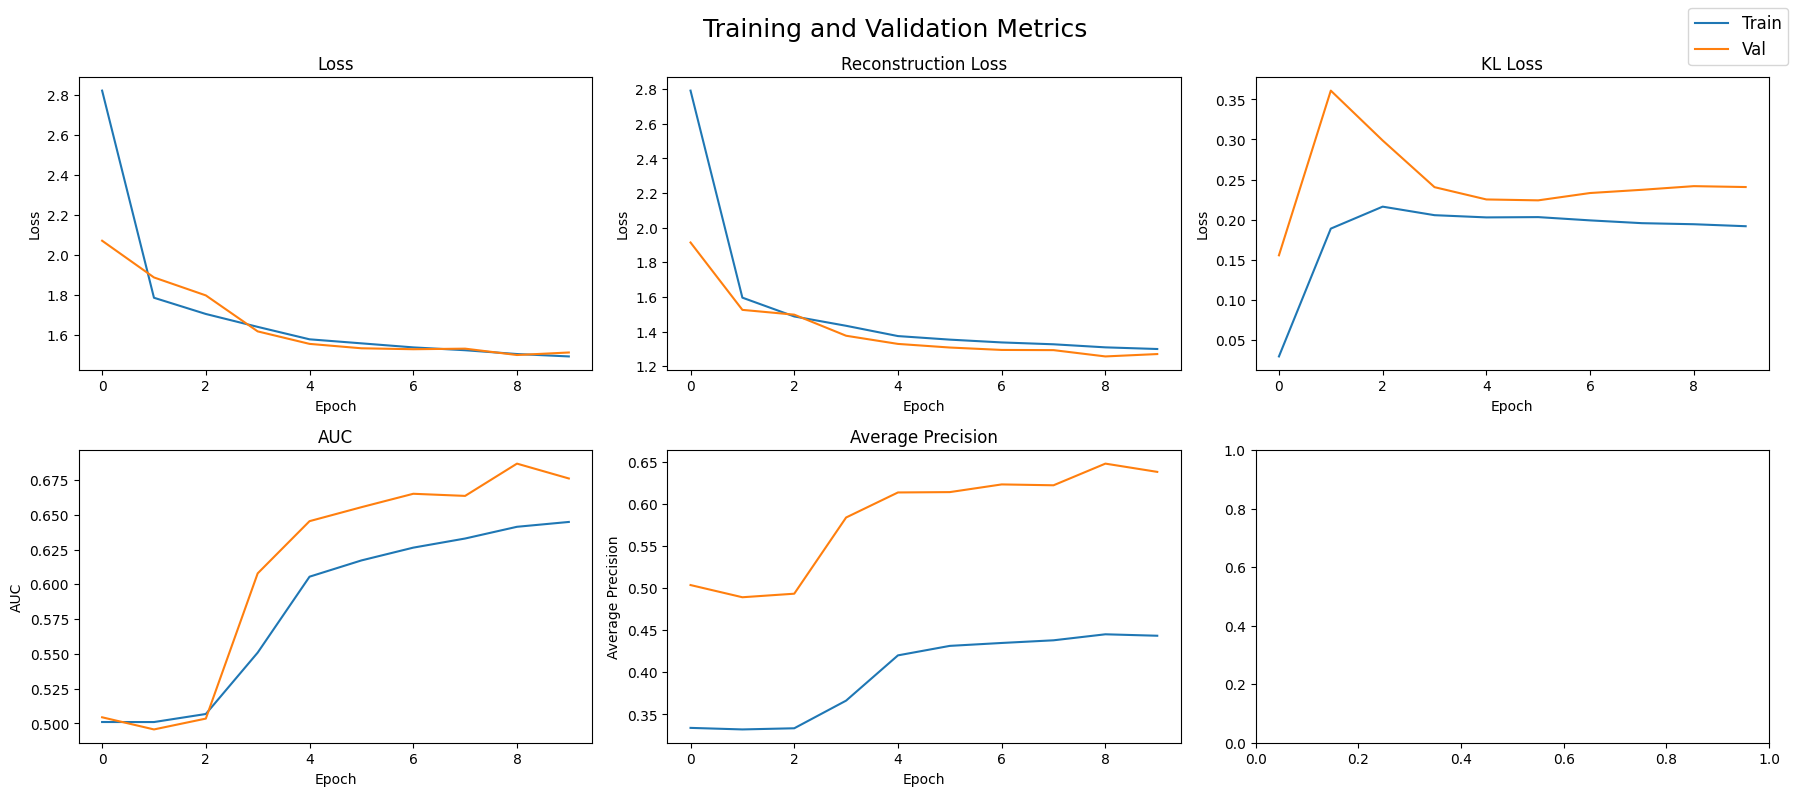

In [ ]:
# Loss Curves
fig, axs = plt.subplots(2, 3, figsize=(18, 8))

# Loss
axs[0][0].plot(history["train"]["loss"], label="Train")
axs[0][0].plot(history["val"]["loss"], label="Val")
axs[0][0].set_title("Loss")
axs[0][0].set_xlabel("Epoch")
axs[0][0].set_ylabel("Loss")

# Rec Loss
axs[0][1].plot(history["train"]["loss_recon"])
axs[0][1].plot(history["val"]["loss_recon"])
axs[0][1].set_title("Reconstruction Loss")
axs[0][1].set_xlabel("Epoch")
axs[0][1].set_ylabel("Loss")

# KL Divergence Loss
axs[0][2].plot(history["train"]["loss_kl"])
axs[0][2].plot(history["val"]["loss_kl"])
axs[0][2].set_title("KL Loss")
axs[0][2].set_xlabel("Epoch")
axs[0][2].set_ylabel("Loss")

# AUC
axs[1][0].plot(history["train"]["auc"])
axs[1][0].plot(history["val"]["auc"])
axs[1][0].set_title("AUC")
axs[1][0].set_xlabel("Epoch")
axs[1][0].set_ylabel("AUC")

# Average Precision
axs[1][1].plot(history["train"]["average_precision"])
axs[1][1].plot(history["val"]["average_precision"])
axs[1][1].set_title("Average Precision")
axs[1][1].set_xlabel("Epoch")
axs[1][1].set_ylabel("Average Precision")

# Set a single legend for the whole figure
lines_labels = [axs[0][0].get_lines()[0], axs[0][0].get_lines()[1]]
labels = ["Train", "Val"]
fig.legend(lines_labels, labels, loc="upper right", fontsize="large")
fig.suptitle("Training and Validation Metrics", fontsize=18)
plt.tight_layout()
plt.savefig(PLOT_DIR / "training_curves.png")